In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
import transformers

%matplotlib inline

In [2]:
n_validation = 1

In [3]:
class DatasetForClassification(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.token_max_length = 300
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sentence = self.data[idx]["sentence"]
        label = self.data[idx]["miti_code"]
        inputs = tokenizer(sentence, padding="max_length", truncation=True, max_length=self.token_max_length)
        inputs["input_ids"] = torch.tensor(data=inputs["input_ids"], dtype=torch.long)
        inputs["label"] = torch.tensor(label, dtype=torch.long)
        inputs["token_type_ids"] = torch.tensor(data=inputs["token_type_ids"], dtype=torch.long)
        inputs["attention_mask"] = torch.tensor(data=inputs["attention_mask"], dtype=torch.long)
        return inputs

In [4]:
model_name = "cl-tohoku/bert-base-japanese-v3"
model = transformers.BertForSequenceClassification.from_pretrained(model_name, num_labels=7)
tokenizer = transformers.BertJapaneseTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
target_dir = "./datasets/p{}/".format(n_validation)
filenames = ["train.csv", "valid.csv", "test.csv"]

train_df = pd.read_csv(target_dir + filenames[0])
valid_df = pd.read_csv(target_dir + filenames[1])
test_df = pd.read_csv(target_dir + filenames[2])
train_data = train_df.to_dict(orient="records")
valid_data = valid_df.to_dict(orient="records")
test_data = test_df.to_dict(orient="records")

In [6]:
batch_size=16

train_dataset = DatasetForClassification(train_data, tokenizer)
valid_dataset = DatasetForClassification(valid_data, tokenizer)
test_dataset = DatasetForClassification(test_data, tokenizer)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

In [7]:
epochs = 4
no_decay = {"bias", "LayerNorm.weight"}
optimizer_grouped_parameters = [
    {
        "params": [
            param for name, param in model.named_parameters() if not name in no_decay
        ],
        "weight_decay": 0.01,
    },
    {
        "params": [
            param for name, param in model.named_parameters() if name in no_decay
        ],
        "weight_decay": 0.0,
    },
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=1e-5)
#total_step = len(train_dataloader_augmented) * epochs
#scheduler = transformers.optimization.get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_step)
scaler = torch.cuda.amp.GradScaler()

In [8]:
def show_confusion_matrix(actual_label, predicted_label):
    cm = confusion_matrix(actual_label, predicted_label)
    print(cm)

actual_labels = torch.tensor([[1, 2, 3, 4, 5],[1, 3, 4, 5, 6]]) 
predicted_labels = torch.tensor([[2, 3, 4, 4, 5],[4, 4, 4, 5, 6]])

# actual_labelsとpredicted_labelsを1次元のリストに変換
actual_labels_list = actual_labels.flatten().tolist()
predicted_labels_list = predicted_labels.flatten().tolist()

# 混同行列の作成
cm = confusion_matrix(actual_labels_list, predicted_labels_list)

# 混同行列を出力
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[0 1 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 0 2 0 0]
 [0 0 0 2 0 0]
 [0 0 0 0 2 0]
 [0 0 0 0 0 1]]


In [9]:
trainlosslist = []
trainacclist = []
validacclist = []
train_predicted_labels_list = []
train_actual_labels_list = []

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [10]:
model.to(device)
train_predicted_labels_list = []
train_actual_labels_list = []
valid_predicted_labels_list = []
valid_actual_labels_list = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    total_train_acc = 0
    print("epoch", epoch+1, end="   ")
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_masks = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        
        with torch.cuda.amp.autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss.cuda()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        #print("loss:",loss.item())
        total_train_loss += loss.item()
        predictions = np.argmax(outputs.logits.detach().to("cpu").numpy(), axis=1)
        if epoch == epochs-1:
            train_predicted_labels_list.extend(predictions)
            train_actual_labels_list.extend(labels.to("cpu").numpy())
        acc = np.mean(predictions == labels.to("cpu").numpy())
        total_train_acc += acc
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_train_acc = total_train_acc / len(train_dataloader)
    print("train_loss:", avg_train_loss, " ,  train_acc:", avg_train_acc, end=" ,  ")
    trainlosslist.append(avg_train_loss)
    trainacclist.append(avg_train_acc)
    
    

    model.eval()
    total_valid_acc = 0
    for batch in valid_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_masks = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits
        predictions = np.argmax(logits.detach().to("cpu").numpy(), axis=1)
        if epoch == epochs-1:
            valid_predicted_labels_list.extend(predictions)
            valid_actual_labels_list.extend(labels.to("cpu").numpy())
        acc = np.mean(predictions == labels.to("cpu").numpy())
        total_valid_acc += acc
    avg_valid_acc = total_valid_acc / len(valid_dataloader)
    print("valid_acc:", avg_valid_acc)
    validacclist.append(avg_valid_acc)

epoch 1   train_loss: 1.8618128159466911  ,  train_acc: 0.27941176470588236 ,  valid_acc: 0.27777777777777773
epoch 2   train_loss: 1.6049113554113053  ,  train_acc: 0.35661764705882354 ,  valid_acc: 0.3819444444444444
epoch 3   train_loss: 1.4222780115464155  ,  train_acc: 0.5514705882352942 ,  valid_acc: 0.5277777777777778
epoch 4   train_loss: 1.1600032133214615  ,  train_acc: 0.7132352941176471 ,  valid_acc: 0.5763888888888888


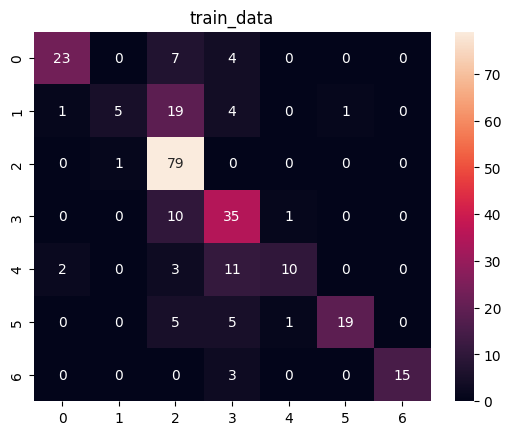

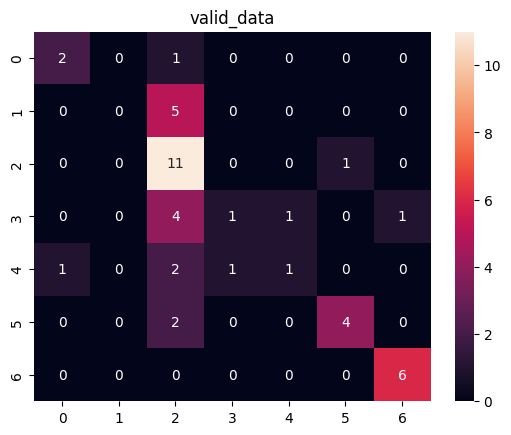

train_precision: [0.88461538 0.83333333 0.64227642 0.56451613 0.83333333 0.95
 1.        ]
train_recall [0.67647059 0.16666667 0.9875     0.76086957 0.38461538 0.63333333
 0.83333333]
[[23  0  7  4  0  0  0]
 [ 1  5 19  4  0  1  0]
 [ 0  1 79  0  0  0  0]
 [ 0  0 10 35  1  0  0]
 [ 2  0  3 11 10  0  0]
 [ 0  0  5  5  1 19  0]
 [ 0  0  0  3  0  0 15]]
valid_precision: [0.66666667 0.         0.44       0.5        0.5        0.8
 0.85714286]
valid_recall [0.66666667 0.         0.91666667 0.14285714 0.2        0.66666667
 1.        ]
[[ 2  0  1  0  0  0  0]
 [ 0  0  5  0  0  0  0]
 [ 0  0 11  0  0  1  0]
 [ 0  0  4  1  1  0  1]
 [ 1  0  2  1  1  0  0]
 [ 0  0  2  0  0  4  0]
 [ 0  0  0  0  0  0  6]]


C:\Users\higak\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:

for i, label in enumerate(train_actual_labels_list):
    if type(train_actual_labels_list[i]) == type(torch.tensor([0])):
        train_actual_labels_list[i] = label.to("cpu").numpy()
cm_train = confusion_matrix(train_actual_labels_list, train_predicted_labels_list)

for i, label in enumerate(valid_actual_labels_list):
    if type(valid_actual_labels_list[i]) == type(torch.tensor([0])):
        valid_actual_labels_list[i] = label.to("cpu").numpy()
cm_valid = confusion_matrix(valid_actual_labels_list, valid_predicted_labels_list)

sns.heatmap(cm_train, annot=True)
if not os.path.exists("./image"):
    os.mkdir("./image")
    os.mkdir("./image/p{}".format(n_validation))
if not os.path.exists("./image/p{}".format(n_validation)):
    os.mkdir("./image/p{}".format(n_validation))
plt.title("train_data")
plt.savefig('./image/p{}/train_confusion_matrix.png'.format(n_validation))
plt.show()
sns.heatmap(cm_valid, annot=True)
plt.title("valid_data")
plt.savefig('./image/p{}/valid_confusion_matrix.png'.format(n_validation))
plt.show()
print("train_precision:",precision_score(train_actual_labels_list, train_predicted_labels_list, average=None))
print("train_recall",recall_score(train_actual_labels_list, train_predicted_labels_list, average=None))
print(cm_train)

precision = precision_score(valid_actual_labels_list, valid_predicted_labels_list, average=None)
print("valid_precision:", precision)
recall = recall_score(valid_actual_labels_list, valid_predicted_labels_list, average=None)
print("valid_recall", recall)
print(cm_valid)

In [ ]:
precision_recall = [np.round(precision, 3), np.round(recall, 3)]
num_labels = 7
print(precision_recall)
rows = ["precision", "recall"]
columns = range(num_labels)
pr_df = pd.DataFrame(precision_recall, index=rows, columns=columns)

fig, ax = plt.subplots(figsize=(5,3))
ax.axis("off")
ax.axis("tight")
ax.set_title("valid_data precision_recall", loc="right")
ax.table(cellText=pr_df.values,
         rowLabels=pr_df.index,
        colLabels=pr_df.columns,
        bbox=[0,0.4,2,0.5])

plt.show()

In [ ]:
print(type(torch.tensor([1]))=='torch.Tensor')

In [ ]:
total_test_acc = 0
test_predicted_labels_list = []
test_actual_labels_list = []
for batch in test_dataloader:
    input_ids = batch["input_ids"].to(device)
    attention_masks = batch["attention_mask"].to(device)
    labels = batch["label"].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
    predictions = np.argmax(logits.detach().to("cpu").numpy(), axis=1)
    test_predicted_labels_list.extend(predictions)
    test_actual_labels_list.extend(labels.to("cpu").numpy())
    acc = np.mean(predictions == labels.to("cpu").numpy())
    total_test_acc += acc

avg_test_acc = total_test_acc / len(test_dataloader)
print("test_acc:", avg_test_acc)

In [ ]:
print(test_actual_labels_list)
print(test_predicted_labels_list)

In [ ]:
cm_test = confusion_matrix(test_actual_labels_list, test_predicted_labels_list)
#plt.figure(figsize=(4,4))
sns.heatmap(cm_test, annot=True, xticklabels=range(0, 6), yticklabels=range(0, 6))
plt.title("test_data")
plt.savefig('./image/p{}/test_confusion_matrix.png'.format(n_validation))
plt.show()
print(cm_test)
test_precision = precision_score(test_actual_labels_list, test_predicted_labels_list, average=None)
test_recall = recall_score(test_actual_labels_list, test_predicted_labels_list, average=None)
print("test_precision:", test_precision)
print("test_recall:", test_recall)

それぞれのconfusion matrixをresultの中に保存しておく。

In [ ]:
precision_recall = [np.round(test_precision, 3), np.round(test_recall, 3)]
num_labels = 7
print(precision_recall)
rows = ["precision", "recall"]
columns = range(num_labels)
pr_df = pd.DataFrame(precision_recall, index=rows, columns=columns)

fig, ax = plt.subplots(figsize=(5,3))
ax.axis("off")
ax.axis("tight")
ax.set_title("test_data precision_recall", loc="right")
ax.table(cellText=pr_df.values,
         rowLabels=pr_df.index,
        colLabels=pr_df.columns,
        bbox=[0,0.4,2,0.5])

plt.show()

In [ ]:
save_dir = "./result/p{}/".format(n_validation)
file_names = ["train.npy", "valid.npy", "test.npy"]
confusion_matrices = {
    "train":cm_train,
    "valid":cm_valid,
    "test":cm_test
}
if not os.path.exists("./result"):
    os.mkdir("./result")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for key in confusion_matrices.keys():
    np.save(save_dir + key, confusion_matrices[key])


In [ ]:
ts = np.load(save_dir+"valid.npy")
ts

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(range(epochs), trainacclist, 'b', label='Training Accuracy')
plt.plot(range(epochs), validacclist, 'r', label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.title("augmented_dataset")
plt.legend()
plt.grid()
if not os.path.exists("./image"):
    os.mkdir("./image")
plt.show()

In [ ]:
print(test_actual_labels_list)

In [ ]:
def test_func(sentence, label, tokenizer, model):
    model.to("cpu")
    miticode_list = ["該当なし","単純な聞き返し", "複雑な聞き返し", "開かれた質問", "閉じた質問", "是認", "要約"]
    tokenized_sentence = tokenizer(sentence,  padding="max_length", truncation=True, max_length=300)
    input_ids = torch.tensor([tokenized_sentence["input_ids"]])
    attention_mask = torch.tensor([tokenized_sentence["attention_mask"]])
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    #print(logits)
    prediction = np.argmax(logits.detach().to("cpu").numpy(), axis=1)
    print("入力文",sentence)
    print("正答：", miticode_list[label])
    print("予測：", miticode_list[prediction.item()])

In [ ]:
miticode_list = ["該当なし","単純な聞き返し", "複雑な聞き返し", "開かれた質問", "閉じた質問", "是認", "要約"]

In [ ]:
test_sentence = "この3ヵ月間で彼女のスピード違反切符は3回目です。保険の最高限度額を超えています。彼女を殺したくなります。彼女はそのお金はほかのことに必要なお金だと分からないのでしょうか？"
test_sentence += "[SEP]あなたはそのことでかなり怒っていらっしゃいますね。"
test_func(test_sentence, 1, tokenizer, model)

In [ ]:
test_sentence2 = 'そうですね。転職活動へのやる気を高めたいです。[SEP]やる気を高めて転職活動を行い、来年からは新しい職場で働きたいわけですね。[SEP]そうです。さすがに今の職場で来年度も働くイメージは持てません。'
test_func(test_sentence2, 2, tokenizer, model)